Just imports and making the data as shown in the PDF:

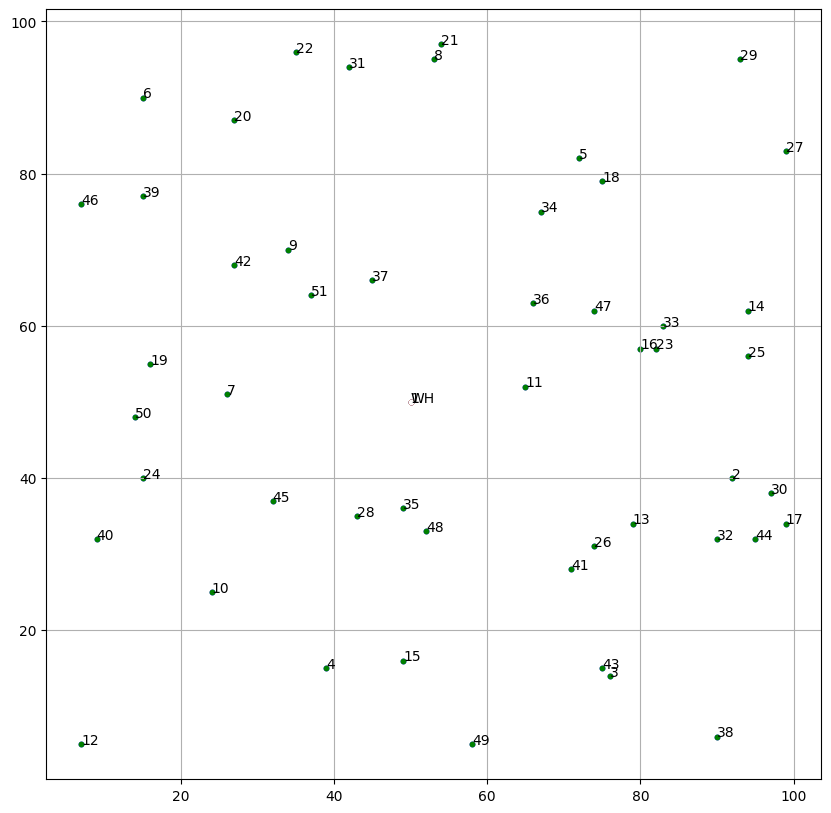

Generation:    0 | Fitness: inf
Generation:   50 | Fitness: 1118.00
Generation:  100 | Fitness: 847.00
Generation:  150 | Fitness: 781.00
Generation:  200 | Fitness: 781.00
Generation:  250 | Fitness: 781.00
Generation:  300 | Fitness: 781.00
Generation:  350 | Fitness: 781.00
Generation:  400 | Fitness: 780.00
Generation:  450 | Fitness: 757.00
Generation:  500 | Fitness: 755.00
Generation:  550 | Fitness: 755.00
Generation:  600 | Fitness: 755.00
Generation:  650 | Fitness: 755.00
Generation:  700 | Fitness: 755.00
Generation:  750 | Fitness: 755.00
Generation:  800 | Fitness: 755.00
Generation:  850 | Fitness: 755.00
Generation:  900 | Fitness: 755.00
Generation:  950 | Fitness: 755.00


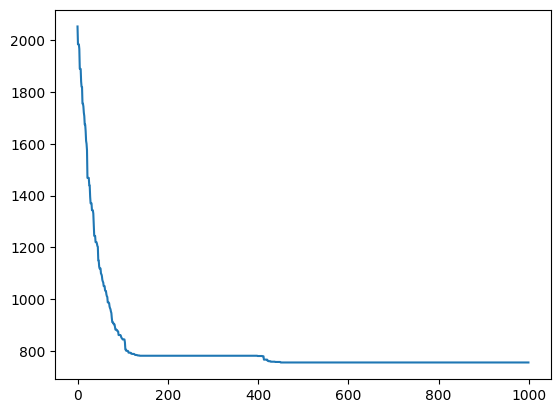

[3, 34, 47, 40, 25, 12, 31, 43, 16, 29, 1, 24, 22, 15, 32, 13, 26, 28, 4, 17, 46, 35, 10, 36, 8, 38, 45, 5, 19, 21, 30, 50, 6, 23, 39, 49, 18, 41, 7, 20, 33, 0, 27, 44, 9, 11, 48, 37, 2, 42, 14]


/tmp/ipykernel_18060/175128384.py:144: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(homes_coord[:, 0],


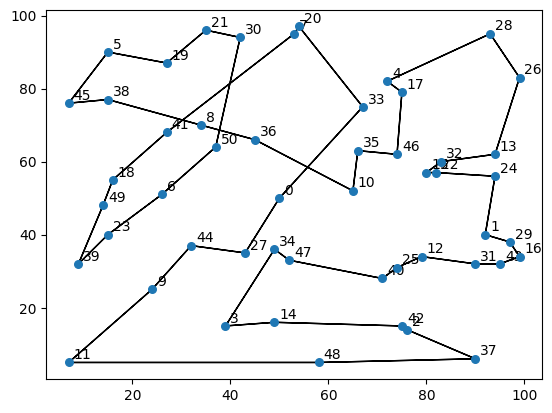

In [1]:
# Traveling Salesman Problem 

import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import time
import pandas as pd
import copy

CustDist_WHCentral = pd.read_csv("CustDist_WHCentral.csv", sep=",", decimal=".")
del CustDist_WHCentral["Distances between Customers and Warehouse"]
CustDist_WHCentral_list = CustDist_WHCentral.values.tolist()

CustDist_WHCorner = pd.read_csv("CustDist_WHCorner.csv", sep=",", decimal=".")
del CustDist_WHCorner["Distances between Customers and Warehouse"]
CustDist_WHCorner_list = CustDist_WHCorner.values.tolist()

CustOrd = pd.read_csv("CustOrd.csv", sep=",", decimal=".")
del CustOrd["Customer"]
CustOrd_list = CustOrd.values.tolist()

CustPos = pd.read_csv("CustXY_WHCentral.csv", sep=",", decimal=".")
del CustPos["Customer XY"]
CustPos_list = CustPos.values.tolist()


num_homes = len(CustDist_WHCentral_list)

# plot a grid of positions of the homes with the warehouse in the center with order number
plt.figure(figsize=(10,10))
plt.scatter([x[0] for x in CustPos_list], [x[1] for x in CustPos_list], s=10, c='b')
plt.scatter([x[0] for x in CustPos_list], [x[1] for x in CustPos_list], s=10, c='g')
for i in range(num_homes):
    plt.text(CustPos_list[i][0], CustPos_list[i][1], str(i+1), fontsize=10)
plt.scatter(CustPos_list[0][0], CustPos_list[0][1], s=10, c='r')
plt.scatter(CustPos_list[0][0], CustPos_list[0][1], s=10, c='w')
plt.text(CustPos_list[0][0], CustPos_list[0][1], 'WH', fontsize=10)
plt.grid()
plt.show()


homes_names = [i for i in range(num_homes)]
homes_coord = np.array(CustPos_list)


np.random.seed(64)  # we are setting the same random seed to be able to reproduce the answers.

def chromo_create(_homes_names):
    chromo = copy.deepcopy(_homes_names)
    np.random.shuffle(chromo)    
    return chromo

def chromo_eval(_dist_matrix, _chromo):
    dist = 0
    for p in range(len(_chromo) - 1):
        _i = _chromo[p]
        _j = _chromo[p+1]
        dist += _dist_matrix[_i][_j]
        
    dist += dist_matrix[_chromo[-1], _chromo[0]]
    return dist,

tb = base.Toolbox()
creator.create('Fitness_Func', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.Fitness_Func)


num_population = 2000
num_generations = 1000
prob_crossover = .4
prob_mutation = .6

dist_matrix = np.array(CustDist_WHCentral_list)



tb.register('indexes', chromo_create, homes_names)
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
tb.register('population', tools.initRepeat, list, tb.individual)
tb.register('evaluate', chromo_eval, dist_matrix)
tb.register('select', tools.selTournament)
tb.register('mate', tools.cxPartialyMatched)
tb.register('mutate', tools.mutShuffleIndexes)

population = tb.population(n=num_population)

fitness_set = list(tb.map(tb.evaluate, population))
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

best_fit_list = []
best_sol_list = []

best_fit = np.Inf

for gen in range(0, num_generations):
    
    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' )   # print the generation and their fitness level
    
    offspring = tb.select(population, len(population), tournsize=3)
    offspring = list(map(tb.clone, offspring))
    
    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo, indpb=0.01)
            del chromo.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitness_set = map(tb.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]
    
    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)

plt.plot(best_fit_list)
plt.show()

print(best_sol)

final_sol = best_sol + best_sol[0:1]

plot_size   = 15
plot_width  = 16
plot_height = 8

plt.scatter(homes_coord[:, 0], 
            homes_coord[:, 1], 
            s=plot_size*2, 
            cmap='viridis',
            zorder = 10000);

for i, txt in enumerate(homes_names):
    plt.annotate(txt, (homes_coord[i, 0]+1, homes_coord[i, 1]+1))

lines = []
for p in range(len(final_sol) - 1):
    i = final_sol[p]
    j = final_sol[p+1]
    colour = 'black'       
    plt.arrow(homes_coord[i][0], 
              homes_coord[i][1],
              homes_coord[j][0] - homes_coord[i][0], 
              homes_coord[j][1] - homes_coord[i][1], 
              color=colour)

Start the funny part